In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import csv
import seaborn as sns

cudnn.benchmark = True
plt.ion()   # interactive mode

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/drive/MyDrive/STUDY/DeepStream/image"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes # (0: blue, 1: white, 2: black)
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['0', '1', '2']


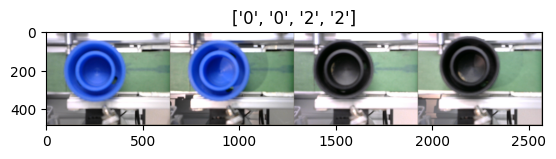

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Specify the path to save the best model parameters
    best_model_params_path = '/content/drive/MyDrive/STUDY/DeepStream/color-best-edc.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)#.float()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() #Tính đạo hàm
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}-true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# model_conv = torchvision.models.resnet34(weights="IMAGENET1K_V1")
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# model_conv = models.quantization.resnet18(pretrained=True, quantize=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.2MB/s]


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7198 Acc: 0.6842
val Loss: 0.3998 Acc: 0.8583

Epoch 1/24
----------
train Loss: 0.3917 Acc: 0.8704
val Loss: 0.0956 Acc: 0.9896

Epoch 2/24
----------
train Loss: 0.3870 Acc: 0.8583
val Loss: 0.0443 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3349 Acc: 0.8583
val Loss: 0.0373 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.3352 Acc: 0.8826
val Loss: 0.0232 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2764 Acc: 0.9049
val Loss: 0.0576 Acc: 0.9792

Epoch 6/24
----------
train Loss: 0.2536 Acc: 0.9049
val Loss: 0.0158 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2130 Acc: 0.9352
val Loss: 0.0150 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1268 Acc: 0.9676
val Loss: 0.0140 Acc: 1.0000

Epoch 9/24
----------


ConvNet as fixed feature extractor

In [ ]:
# Important to freeze the final connect
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train model

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6963 Acc: 0.7186
val Loss: 0.3760 Acc: 0.7917

Epoch 1/24
----------
train Loss: 0.4362 Acc: 0.8300
val Loss: 0.1088 Acc: 0.9938

Epoch 2/24
----------
train Loss: 0.2799 Acc: 0.9130
val Loss: 0.0590 Acc: 0.9958

Epoch 3/24
----------
train Loss: 0.2216 Acc: 0.9352
val Loss: 0.0335 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2888 Acc: 0.8927
val Loss: 0.0280 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2590 Acc: 0.9049
val Loss: 0.0183 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2192 Acc: 0.9352
val Loss: 0.0183 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1691 Acc: 0.9514
val Loss: 0.0129 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1928 Acc: 0.9352
val Loss: 0.0163 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1845 Acc: 0.9453
val Loss: 0.0147 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1748 Acc: 0.9453
val Loss: 0.0182 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1458 Acc: 0.9636
val Loss: 0.0131 Acc: 1.0000

Ep

Show task bar

[[163.   0.   0.]
 [  0. 160.   0.]
 [  0.   0. 157.]]


Text(0.5, 80.7222222222222, 'Predicted label')

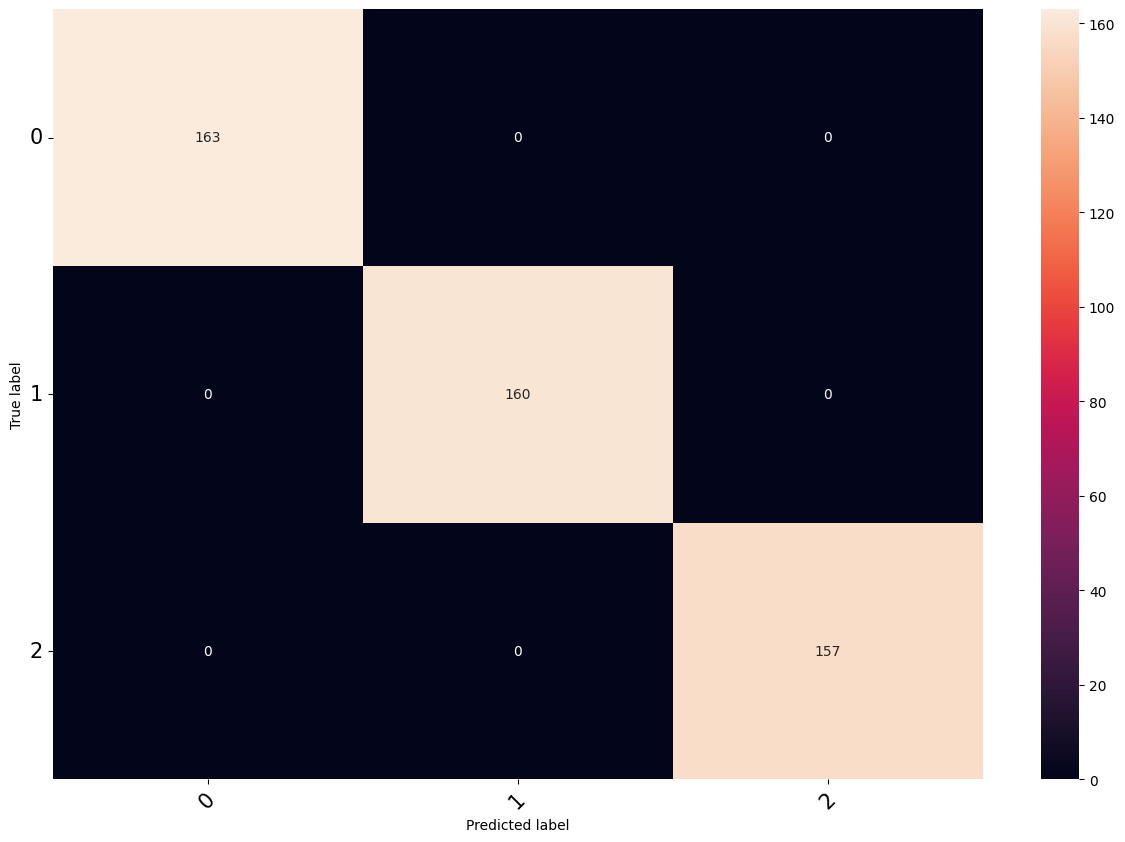

In [ ]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)
plt.figure(figsize=(15,10))

# class_names_list = list(class_names.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='center',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

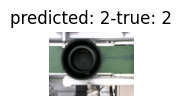

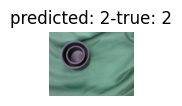

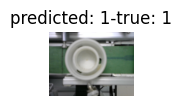

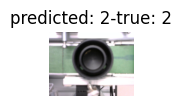

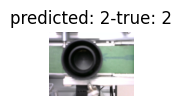

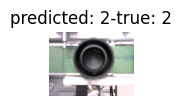

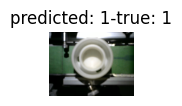

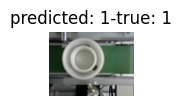

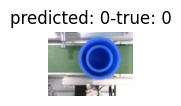

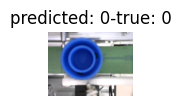

In [ ]:
model_conv.load_state_dict(torch.load('/content/drive/MyDrive/STUDY/DeepStream/color-best-edc.pt'))
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def check_image(csv_path,name):
    with open(csv_path, "r") as csvfile:

    # Khởi tạo reader
        reader = csv.reader(csvfile, delimiter=",")
        for row in reader:
            if name in row:
                num_row =reader.line_num
                # In ra số thứ tự của hàng
                print(f"Hàng {num_row} có chứa {name}")
    return num_row

csv_path = "/content/drive/MyDrive/STUDY/train-model/csv/data.csv"
name = "Image_0007.jpg"
labels = check_image(csv_path,name)
print(labels)
# check_image(csv_path,name)

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()
    # df = pd.read_csv(csv_path)
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    name = os.path.basename(img_path)
    # row = check_image(csv_path,name)
    # labels = df.iloc[:,8]


    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


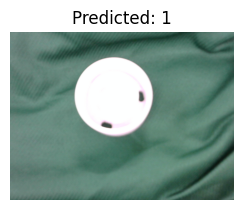

In [ ]:
model_conv.load_state_dict(torch.load('/content/drive/MyDrive/STUDY/DeepStream/color-best-edc.pt'))
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/STUDY/DeepStream/image/train/1/white_707.png'
)

plt.ioff()
plt.show()

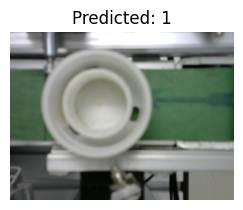

In [ ]:
# Create an instance of ResNet18
model_conv = models.resnet18()
# Replace the fully connected layer with a new one having 2 output units
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
model_conv = model_conv.to(device)
# Load the state dictionary into the ResNet18 model
state_dict = torch.load('/content/drive/MyDrive/STUDY/train-model/model/color-best.pt')

# Load the adapted state dictionary into the model
model_conv.load_state_dict(state_dict)

model_conv.eval()  # Set the model to evaluation mode
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/STUDY/train-model/img/val/1/white_0.png'
)

plt.ioff()
plt.show()